# Dynamic Programming
## Exercise 4.7: Car Rental Example

For dynamic programming, we need the full transition and reward model of the environment. Important notes are, for the original problem:

* 10 per car rented out
* 2 cost per car moved
* Poisson RVs for cars requested and returned. Requests has $\lambda_1 = 3$, $\lambda_2 = 4$ whilst returns has $\lambda_1 = 3$ and $\lambda_2=2$.
* No more than 20 cars at any location.  
* Max 5 cars can be moved at one. 
* $\gamma=0.9$
* $s = [\text{cars at loc 1} ; \text{cars at loc 2}]$
* $a \in \lbrace -5, -4, \dots, 5 \rbrace$. Positive $a$ moves car from location $1$ to $2$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import poisson

%matplotlib inline

import copy
import itertools

In [2]:
# maximum here is INCLUSIVE
def compute_truncated_poisson(mu, maximum):
    pmf = [(x, poisson.pmf(x, mu)) for x in range(maximum)]
    pmf.append((maximum, 1-np.sum([p for _, p in pmf])))
    return pmf

def dynamics_model_original(s, a, const_returned_cars=True, max_cars=20):
    # make our life a little bit easier by truncating how many things are considered. 
    
    # the dynamics model takes in s, a and returns a list of tuples of (p, s', r)
    # where p is the probability of the outcome, s' is the new state and r is the 
    # reward received
    #
    # assume that the dynamics model receives a valid state action pair
    
#     if np.max(s) > max_cars or np.min(s) < 0:
#             raise ValueError("You fed the dynamics model an invalid state")
    
    # state is the number of cars at the end of the day. Therefore, movement happens first.
    new_state = copy.deepcopy(s)
    
    if not a==0:
        new_state[0] -= a
        new_state[1] += a
        
        # cost of moving the cars
        base_reward = -2 * np.abs(a)
        
        if np.max(new_state) > max_cars or np.min(new_state) < 0:
            raise ValueError("You fed the dynamics model an invalid action")
    else:
        base_reward = 0
            
    # compute possibilities of each state    
    # lets allow everything and just clip ...
    # the reproduction uses 11
    if not const_returned_cars:
        cars_arriving_loc_1 = compute_truncated_poisson(3, 11)
        cars_arriving_loc_2 = compute_truncated_poisson(2, 11)
    else:
        cars_arriving_loc_1 = [(3, 1.0)]
        cars_arriving_loc_2 = [(2, 1.0)]
        
    cars_leaving_loc_1 = compute_truncated_poisson(3, 11)
    cars_leaving_loc_2 = compute_truncated_poisson(4, 11)

    all_poss = list(itertools.product(cars_arriving_loc_1, cars_arriving_loc_2, cars_leaving_loc_1, cars_leaving_loc_2))
    
    outcome_poss = []
    
    for aloc1, aloc2, lloc1, lloc2 in all_poss:
        # we need to make sure we handle cars leaving properly, since this is what gets us the reward
        # follow the reproduction code!
        p = aloc1[1] * aloc2[1] * lloc1[1] * lloc2[1]
        rented1 = min(lloc1[0], new_state[0])
        rented2 = min(lloc2[0], new_state[1])
        s_new = np.array([min(new_state[0] - rented1 + aloc1[0], 20), min(new_state[1] - rented2 + aloc2[0], 20)])
        r = base_reward + ((rented1 + rented2) * 10)
        outcome_poss.append((p, s_new, r))
    
    return outcome_poss


def policy_iteration(pi_init, v_init, dynamics_model, theta=2, max_eval=25, gamma=0.9):
    # policy evaluation step
    # ensure that the first step runs
    print("performing policy_evaluation")
    delta = theta + 0.1
    v = copy.deepcopy(v_init)
    pi = copy.deepcopy(pi_init)
    eval_it = 1
    
    all_states = [(x, y) for x in range(21) for y in range(21)]
    while delta > theta and eval_it < max_eval + 1:
        delta = 0
        for x, y in all_states:
            v_temp = copy.deepcopy(v[x, y])
            new_poss = dynamics_model(np.array([x, y]), pi[x, y])
            v[x, y] = np.sum([ p*(r + gamma * v[new_state[0], new_state[1]]) for p, new_state, r in new_poss])
            delta = np.max([delta, np.abs(v[x, y] - v_temp)])
        print(f"Iteration: {eval_it} Delta: {delta}")
        eval_it = eval_it + 1
    
    # perform policy improvement:
    print("performing policy_improvement")
    policy_changed = False
    for x, y in all_states:
        # compute valid a
        a_valid = list(range(-np.min([5, y, 20-x]), np.min([5, x, 20-y])+1, 1))
        a_values = np.zeros(shape=len(a_valid))
        for indx, a in enumerate(a_valid):
            # compute the value of performing a and then following pi
            new_poss = dynamics_model(np.array([x, y]), a)
            a_values[indx] = np.sum([p*(r + gamma * v[new_state[0], new_state[1]]) for p, new_state, r in new_poss])
        
        a_new = a_valid[np.argmax(a_values)]
        if not a_new == pi[x, y]:
            policy_changed = True 
            pi[x, y] = a_new
    
    return v, pi, policy_changed

In [3]:
pi_init = np.zeros(shape=(21, 21))
v_init = 400*np.ones(shape=(21, 21))
history = [(v_init, pi_init)]

max_policy_iteration_steps = 10
pi_it = 0
policy_changed = True

while pi_it < max_policy_iteration_steps and policy_changed:
    print(f"Performing Policy Iteration {pi_it}")
    v, pi, policy_changed = policy_iteration(history[-1][1], history[-1][0], dynamics_model_original)
    history.append([v, pi])
    pi_it += 1
    if not policy_changed:
        print("optimal policy found - terminating")

Performing Policy Iteration 0
performing policy_evaluation
Iteration: 1 Delta: 84.40656266251165
Iteration: 2 Delta: 57.280327731715204
Iteration: 3 Delta: 37.14210297377025
Iteration: 4 Delta: 25.471575395666036
Iteration: 5 Delta: 18.156293959077914
Iteration: 6 Delta: 12.231969615099729
Iteration: 7 Delta: 8.128053446168565
Iteration: 8 Delta: 5.549072386834155
Iteration: 9 Delta: 4.04988310248757
Iteration: 10 Delta: 3.4251276303566556
Iteration: 11 Delta: 2.979094953444303
Iteration: 12 Delta: 2.609946829716307
Iteration: 13 Delta: 2.278890058406148
Iteration: 14 Delta: 1.9845205309686094
performing policy_improvement
Performing Policy Iteration 1
performing policy_evaluation
Iteration: 1 Delta: 77.52702218752876
Iteration: 2 Delta: 7.404658229843335
Iteration: 3 Delta: 3.204574498443094
Iteration: 4 Delta: 2.131854983271978
Iteration: 5 Delta: 1.865865261122508
performing policy_improvement
Performing Policy Iteration 2
performing policy_evaluation
Iteration: 1 Delta: 5.497019024

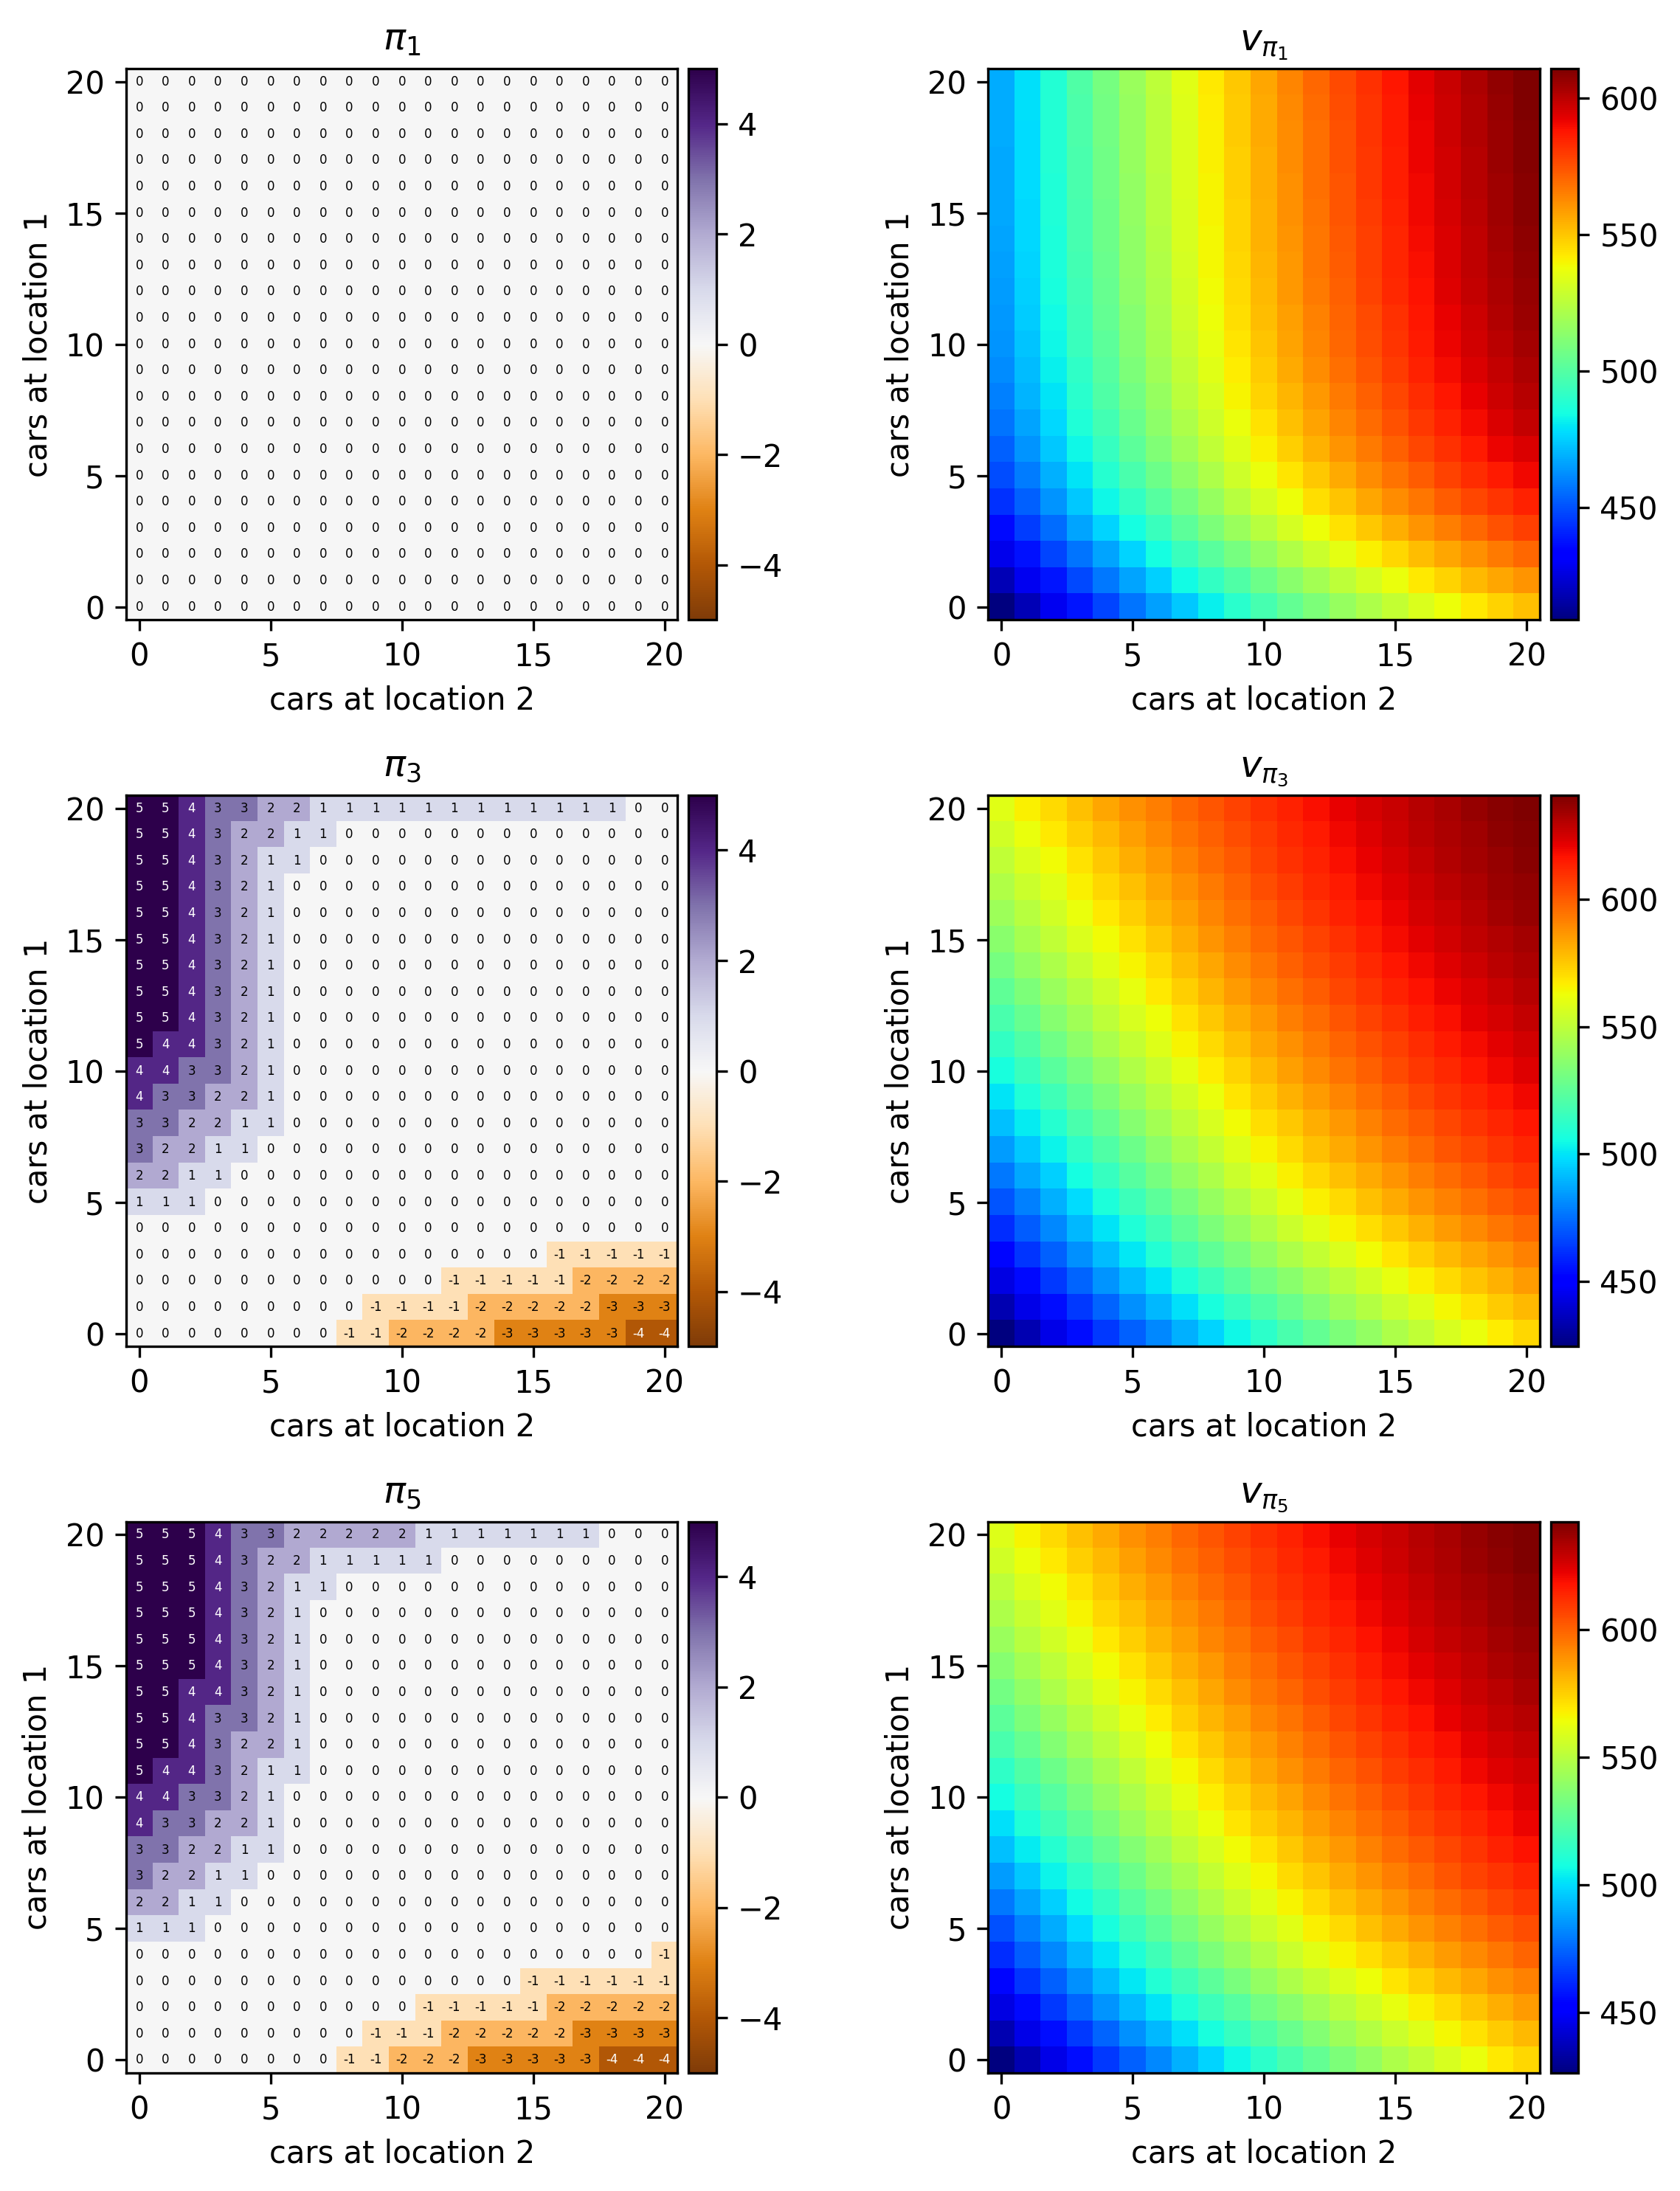

In [22]:
# let's plot the policies that we found. 
plt.figure(figsize=(8, 10), dpi=300)

all_states = [(x, y) for x in range(21) for y in range(21)]
num_pi = len(history)

history_to_plot_indxs = [0, 2, 4]
num_pi = len(history_to_plot_indxs)

for plt_indx, indx in enumerate(history_to_plot_indxs):
    ax = plt.subplot(num_pi, 2, 2*plt_indx+1)
    pi = history[indx][1]
    res = plt.imshow(pi, cmap = plt.cm.PuOr, origin="lower", vmin=-5, vmax=5)
    
    for loc1, loc2 in all_states:
        if np.abs(pi[loc1, loc2]) > 3:
            color = "white"
        else:
            color = "black"
        plt.annotate(f"{int(pi[loc1, loc2]):d}", xy=(loc2, loc1), size=4, horizontalalignment="center", verticalalignment="center", color=color)
    
    plt.xlabel(r"cars at location 2")
    plt.ylabel(r"cars at location 1")
    plt.title(f"$\pi_{indx+1}$")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(res, cax=cax)
    
    ax = plt.subplot(num_pi, 2, 2*plt_indx+2)
    v = history[indx+1][0]
    res = plt.imshow(v, cmap = plt.cm.jet, origin="lower")
    
    plt.xlabel(r"cars at location 2")
    plt.ylabel(r"cars at location 1")
    plt.title(f"$v_{{\\pi_{{{indx+1}}}}}$")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(res, cax=cax)
plt.tight_layout()
plt.savefig("original.pdf")

### Thoughts
Yay! this looks the exact same as what is in the book now. 

In [ ]:
%prun policy_iteration(np.zeros(shape=(21, 21)), 400*np.ones(shape=(21, 21)), dynamics_model_original)

In [3]:
def dynamics_model_alt(s, a, const_returned_cars=True, max_cars=20):
    new_state = copy.deepcopy(s)
    
    if not a==0:
        new_state[0] -= a
        new_state[1] += a
        
        # cost of moving the cars
        # free to move a car from 1 to 2
        base_reward = -2 * np.abs(a) if not a == 1 else 0 
        
        if np.max(new_state) > max_cars or np.min(new_state) < 0:
            raise ValueError("You fed the dynamics model an invalid action")
    else:
        base_reward = 0
    
    if not const_returned_cars:
        cars_arriving_loc_1 = compute_truncated_poisson(3, 11)
        cars_arriving_loc_2 = compute_truncated_poisson(2, 11)
    else:
        cars_arriving_loc_1 = [(3, 1.0)]
        cars_arriving_loc_2 = [(2, 1.0)]
        
    cars_leaving_loc_1 = compute_truncated_poisson(3, 11)
    cars_leaving_loc_2 = compute_truncated_poisson(4, 11)

    all_poss = list(itertools.product(cars_arriving_loc_1, cars_arriving_loc_2, cars_leaving_loc_1, cars_leaving_loc_2))
    
    outcome_poss = []
    
    for aloc1, aloc2, lloc1, lloc2 in all_poss:
        p = aloc1[1] * aloc2[1] * lloc1[1] * lloc2[1]
        rented1 = min(lloc1[0], new_state[0])
        rented2 = min(lloc2[0], new_state[1])
        s_new = np.array([min(new_state[0] - rented1 + aloc1[0], 20), min(new_state[1] - rented2 + aloc2[0], 20)])
        r = base_reward + ((rented1 + rented2) * 10) - 4 * np.sum(s_new > 10)
        outcome_poss.append((p, s_new, r))
    
    return outcome_poss

In [4]:
pi_init = np.zeros(shape=(21, 21))
v_init = 400*np.ones(shape=(21, 21))
history_modified = [(v_init, pi_init)]

max_policy_iteration_steps = 20
pi_it = 0
policy_changed = True

while pi_it < max_policy_iteration_steps and policy_changed:
    print(f"Performing Policy Iteration {pi_it}")
    v, pi, policy_changed = policy_iteration(history_modified[-1][1], history_modified[-1][0], dynamics_model_alt)
    history_modified.append([v, pi])
    pi_it += 1
    if not policy_changed:
        print("optimal policy found - terminating")

Performing Policy Iteration 0
performing policy_evaluation
Iteration: 1 Delta: 63.83749863328808
Iteration: 2 Delta: 44.53802996452288
Iteration: 3 Delta: 29.676303956182096
Iteration: 4 Delta: 23.902994842583155
Iteration: 5 Delta: 17.380736326974557
Iteration: 6 Delta: 11.790419706346995
Iteration: 7 Delta: 7.798810866194287
Iteration: 8 Delta: 5.253908477666755
Iteration: 9 Delta: 3.7185336852243154
Iteration: 10 Delta: 3.16287155522906
Iteration: 11 Delta: 2.742395650704225
Iteration: 12 Delta: 2.368913361634668
Iteration: 13 Delta: 2.0408739545740104
Iteration: 14 Delta: 1.7548813690868315
performing policy_improvement
Performing Policy Iteration 1
performing policy_evaluation
Iteration: 1 Delta: 102.2672878229456
Iteration: 2 Delta: 10.574612549412336
Iteration: 3 Delta: 5.440093715142893
Iteration: 4 Delta: 3.203646205770724
Iteration: 5 Delta: 2.824493692102237
Iteration: 6 Delta: 2.4851616956535736
Iteration: 7 Delta: 2.158185317198729
Iteration: 8 Delta: 1.8635829065049165
pe

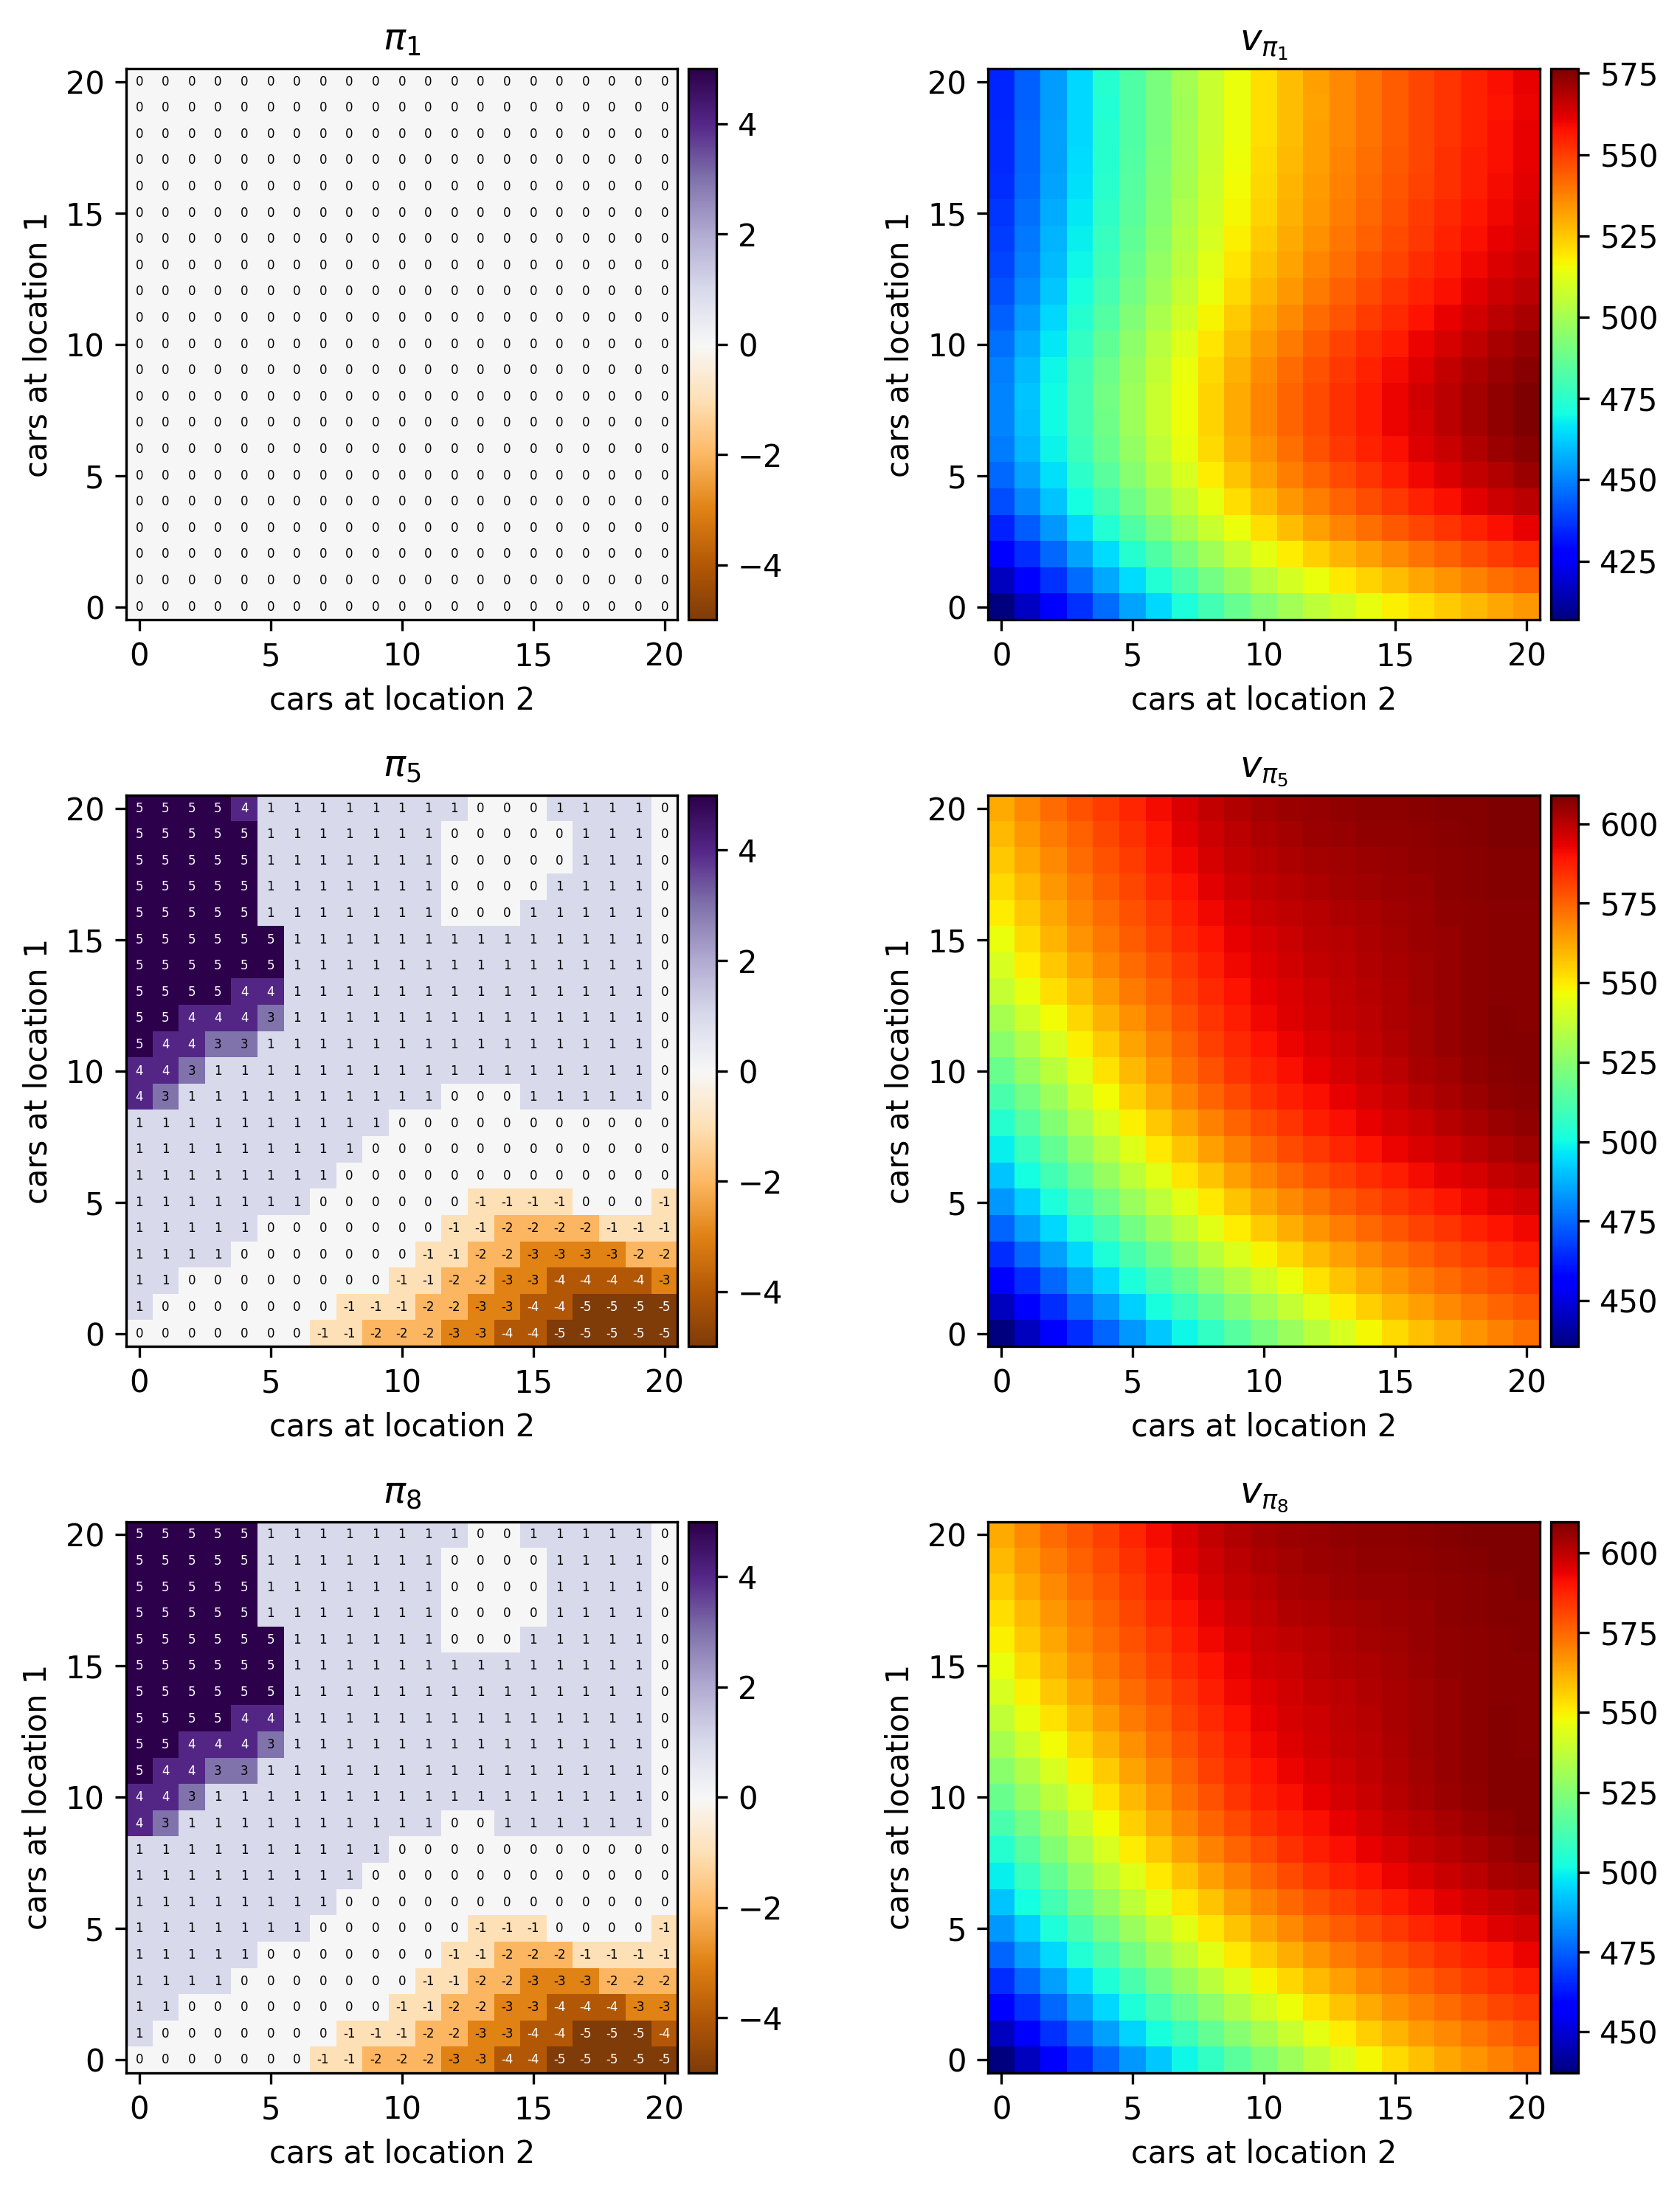

In [9]:
plt.figure(figsize=(8, 10), dpi=300)

all_states = [(x, y) for x in range(21) for y in range(21)]

# history_to_plot_indxs = list(range(len(history_modified)-1))
history_to_plot_indxs = [0, 4, 7]
num_pi = len(history_to_plot_indxs)

for plt_indx, indx in enumerate(history_to_plot_indxs):
    ax = plt.subplot(num_pi, 2, 2*plt_indx+1)
    pi = history_modified[indx][1]
    res = plt.imshow(pi, cmap = plt.cm.PuOr, origin="lower", vmin=-5, vmax=5)
    
    for loc1, loc2 in all_states:
        if np.abs(pi[loc1, loc2]) > 3:
            color = "white"
        else:
            color = "black"
        plt.annotate(f"{int(pi[loc1, loc2]):d}", xy=(loc2, loc1), size=4, horizontalalignment="center", verticalalignment="center", color=color)
    
    plt.xlabel(r"cars at location 2")
    plt.ylabel(r"cars at location 1")
    plt.title(f"$\pi_{indx+1}$")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(res, cax=cax)
    
    ax = plt.subplot(num_pi, 2, 2*plt_indx+2)
    v = history_modified[indx+1][0]
    res = plt.imshow(v, cmap = plt.cm.jet, origin="lower")
    
    plt.xlabel(r"cars at location 2")
    plt.ylabel(r"cars at location 1")
    plt.title(f"$v_{{\\pi_{{{indx+1}}}}}$")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(res, cax=cax)
plt.tight_layout()
plt.savefig("modified.pdf")

This has a pretty wacky shape. We play 1 quite as lot as it's free, and I suppose that this is to be expected. 